---
### Imports

In [6]:
import pandas as pd
import torch
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

---
### Load Dataset
##### Train:

In [7]:
data_frame_train = pd.read_csv('./dataset/train.csv')
x = data_frame_train.drop('price_range', axis=1)
y = data_frame_train['price_range']

In [8]:
x

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1


In [9]:
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, random_state=42)

In [11]:
x_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
836,902,1,0.6,1,0,0,63,0.7,122,5,14,364,1360,3654,18,8,15,0,1,1
575,1197,1,0.5,1,9,0,20,0.1,129,5,10,214,1710,2885,19,7,14,1,1,1
557,1519,0,2.1,0,0,0,32,0.7,200,1,10,168,1239,2912,11,10,15,1,1,0
1235,1971,1,0.5,1,0,0,40,0.3,186,7,19,485,922,571,8,7,17,1,1,0
1360,882,0,0.7,1,9,1,28,0.2,151,6,16,248,884,751,19,11,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1975,1,1.9,1,2,0,31,0.9,151,1,17,775,1607,3022,13,5,19,0,0,1
1294,589,1,0.5,0,1,1,59,0.7,146,8,4,759,1858,362,16,10,6,1,1,1
860,1829,1,0.5,0,0,1,15,0.4,160,5,7,729,1267,2080,16,11,12,1,0,1
1459,1927,0,0.9,1,3,0,11,0.4,190,8,12,491,1506,2916,16,11,18,0,1,1


---
### Preprocessing

In [12]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

In [13]:
x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

---
### Normalization (Standardization)

In [14]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

---
### Dataloader

In [15]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=200, shuffle=False)

---
### Define Model

In [16]:
num_feats = 20
out_feats = 4
h1 = 64
h2 = 32

model = torch.nn.Sequential(torch.nn.Linear(num_feats, h1),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h1, h2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h2, out_feats))
model

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)

---
### Device

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
device

'cuda'

---
### Loss Function

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()

---
### Optimizer

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
### AverageMeter

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

---
### Train Model

In [21]:
epochs = 800

In [22]:
hist_loss_train = []
hist_loss_valid = []

hist_acc_train = []
hist_acc_valid = []

In [23]:
for epoch in range(epochs):
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        predict = model(data)
        loss = loss_fn(predict.squeeze(), target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(predict, target)

    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict.squeeze(), target)

            loss_valid.update(loss.item())
            acc_valid(predict, target)

    hist_loss_train.append(loss_train.avg)
    hist_loss_valid.append(loss_valid.avg)

    hist_acc_train.append(acc_train.compute().cpu())
    hist_acc_valid.append(acc_valid.compute().cpu())

    if epoch % 5 == 0:
        print(f"Epoch: {epoch},")
        print(f"Train Loss: {loss_train.avg:.3}, Acc: {acc_train.compute():.3}")
        print(f"Valid Loss: {loss_valid.avg:.3}, Acc: {acc_valid.compute():.3} \n")


Epoch: 0,
Train Loss: 1.39, Acc: 0.233
Valid Loss: 1.38, Acc: 0.245 

Epoch: 5,
Train Loss: 1.38, Acc: 0.275
Valid Loss: 1.37, Acc: 0.317 

Epoch: 10,
Train Loss: 1.36, Acc: 0.369
Valid Loss: 1.36, Acc: 0.388 

Epoch: 15,
Train Loss: 1.35, Acc: 0.441
Valid Loss: 1.35, Acc: 0.477 

Epoch: 20,
Train Loss: 1.33, Acc: 0.494
Valid Loss: 1.33, Acc: 0.51 

Epoch: 25,
Train Loss: 1.3, Acc: 0.525
Valid Loss: 1.3, Acc: 0.517 

Epoch: 30,
Train Loss: 1.27, Acc: 0.539
Valid Loss: 1.26, Acc: 0.538 

Epoch: 35,
Train Loss: 1.22, Acc: 0.545
Valid Loss: 1.21, Acc: 0.557 

Epoch: 40,
Train Loss: 1.16, Acc: 0.55
Valid Loss: 1.15, Acc: 0.558 

Epoch: 45,
Train Loss: 1.08, Acc: 0.559
Valid Loss: 1.07, Acc: 0.565 

Epoch: 50,
Train Loss: 1.0, Acc: 0.577
Valid Loss: 0.989, Acc: 0.58 

Epoch: 55,
Train Loss: 0.923, Acc: 0.611
Valid Loss: 0.912, Acc: 0.618 

Epoch: 60,
Train Loss: 0.85, Acc: 0.664
Valid Loss: 0.841, Acc: 0.678 

Epoch: 65,
Train Loss: 0.785, Acc: 0.708
Valid Loss: 0.779, Acc: 0.728 

Epoch: 7

---
### Plot

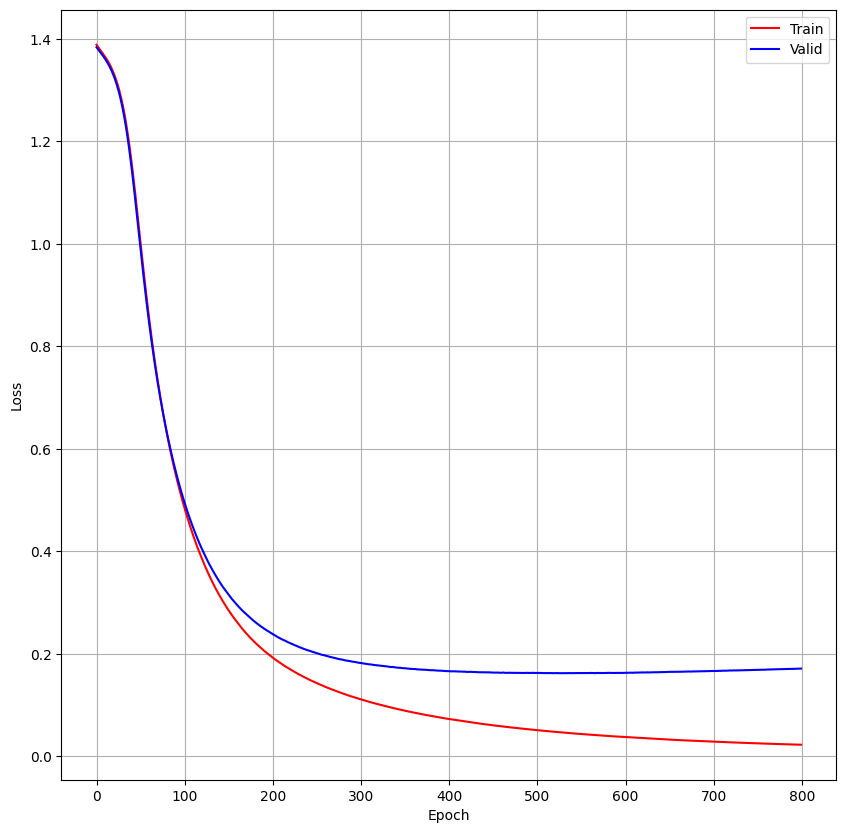

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_loss_train, 'r-', label='Train')
ax.plot(range(epochs), hist_loss_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend()

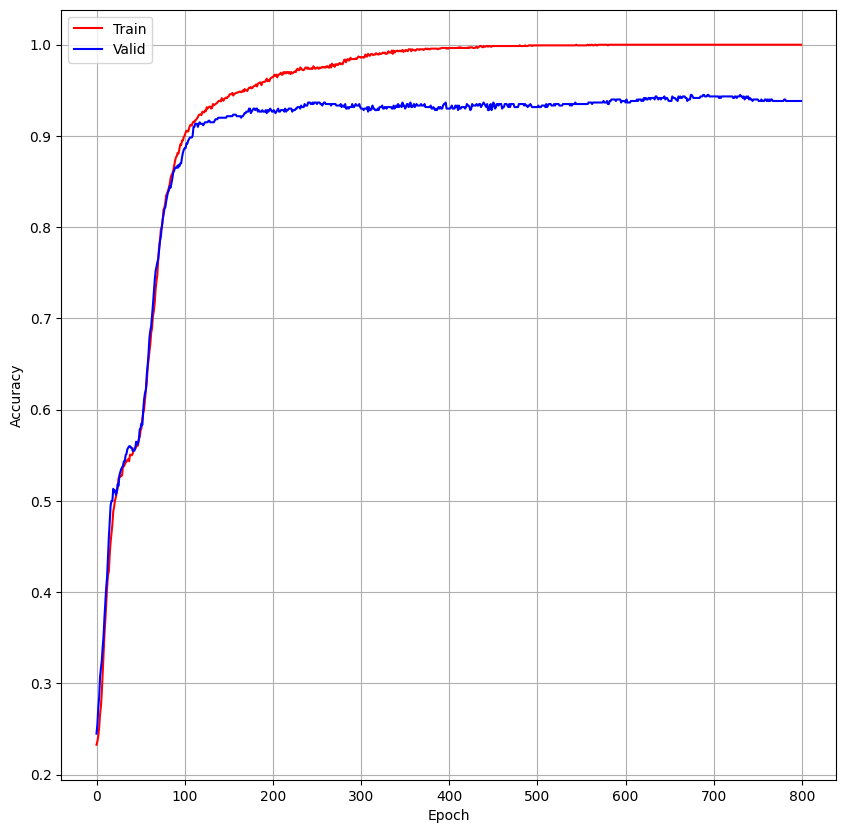

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_acc_train, 'r-', label='Train')
ax.plot(range(epochs), hist_acc_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()

---
### Save Model

In [28]:
torch.save(model, './model.pt')

In [29]:
torch.load('./model.pt', weights_only=False)

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)